## Data analysis

In [1]:
from nnAudio import Spectrogram
import librosa
import torch
from normalization import Normalization



SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
N_BINS = 229 # Default using Mel spectrograms
r = 2
N_BINS = 88*r
spectrogram_function = Spectrogram.CQT1992v2(sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                                            n_bins=N_BINS, fmin=27.5,
                                            bins_per_octave=12*r, trainable=False)


def pass_through_spectrogram_function(audio_path, normalize=False, normalize_mode='framewise'):
    normalization_function = Normalization(normalize_mode)
    audio, _= librosa.load(
            audio_path, dtype='float32', mono=True, sr=SAMPLE_RATE)
    audio = torch.FloatTensor(audio)
    input = audio.reshape(-1, audio.shape[-1])[:, :-1]
    spec = spectrogram_function(input)
    if normalize:
        spec = normalization_function.transform(spec)
    spec = spec.transpose(-1, -2)  # shape (8,640,229)

    spectrogram_result = spec.cpu().detach().numpy()[0]
    return spectrogram_result.transpose(), audio

/Users/mles/Projects/AutomaticMusicTranscription/automatic_music_transcription/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CQT kernels created, time used = 0.3020 seconds


Getting data from:
synthesize_trumpet
synthesize_acoustic_grand_piano
synthesize_acoustic_guitar_nylon


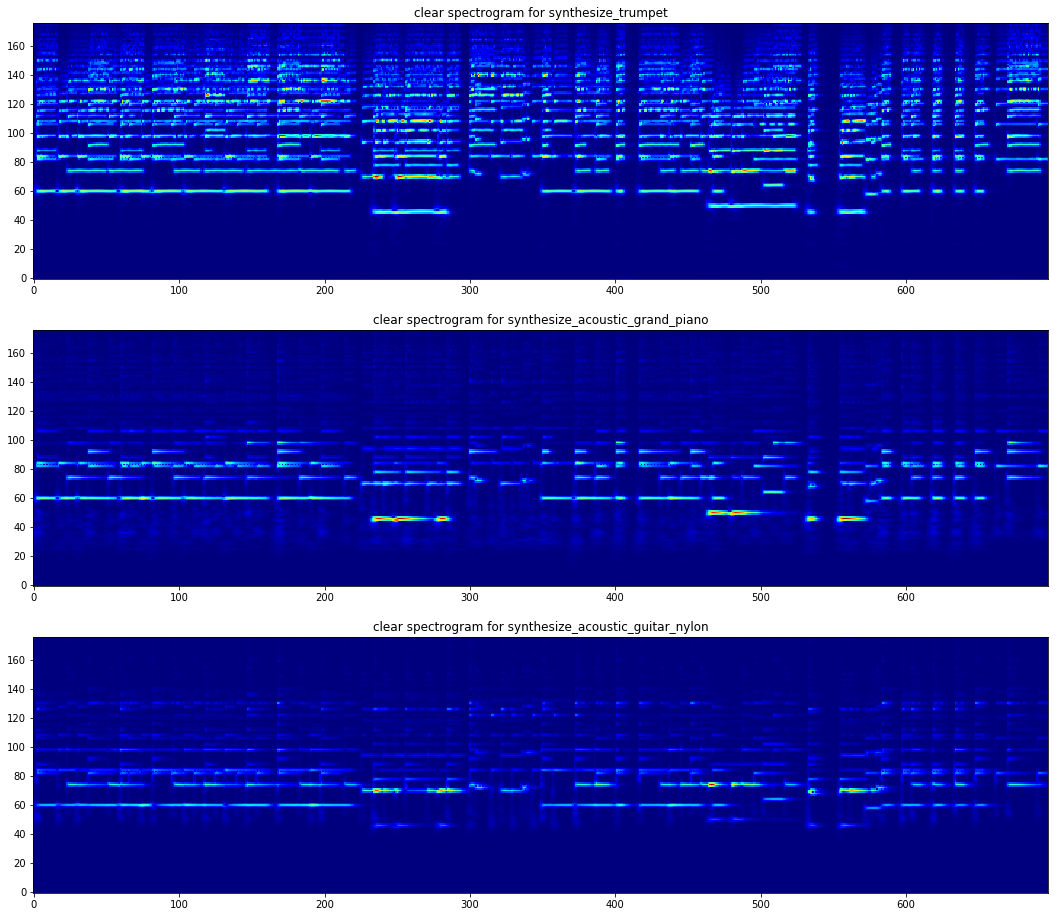

In [2]:

import matplotlib.pyplot as plt
print("Getting data from:")

datasets_names = [
    "synthesize_trumpet",
    "synthesize_acoustic_grand_piano",
    "synthesize_acoustic_guitar_nylon"
]


fig, axs = plt.subplots(3, 1, figsize=(48, 16))
axs = axs.flat

for i, dataset in enumerate(datasets_names):
    print(dataset)
    spectrogram_result, _ = pass_through_spectrogram_function(f"{dataset}/test/audio/00_BN1-129-Eb_comp_hex.wav")
    axs[i].imshow(spectrogram_result, cmap='jet', origin='lower')
    axs[i].title.set_text(f"clear spectrogram for {dataset}")



synthesize_trumpet
synthesize_acoustic_grand_piano
synthesize_acoustic_guitar_nylon


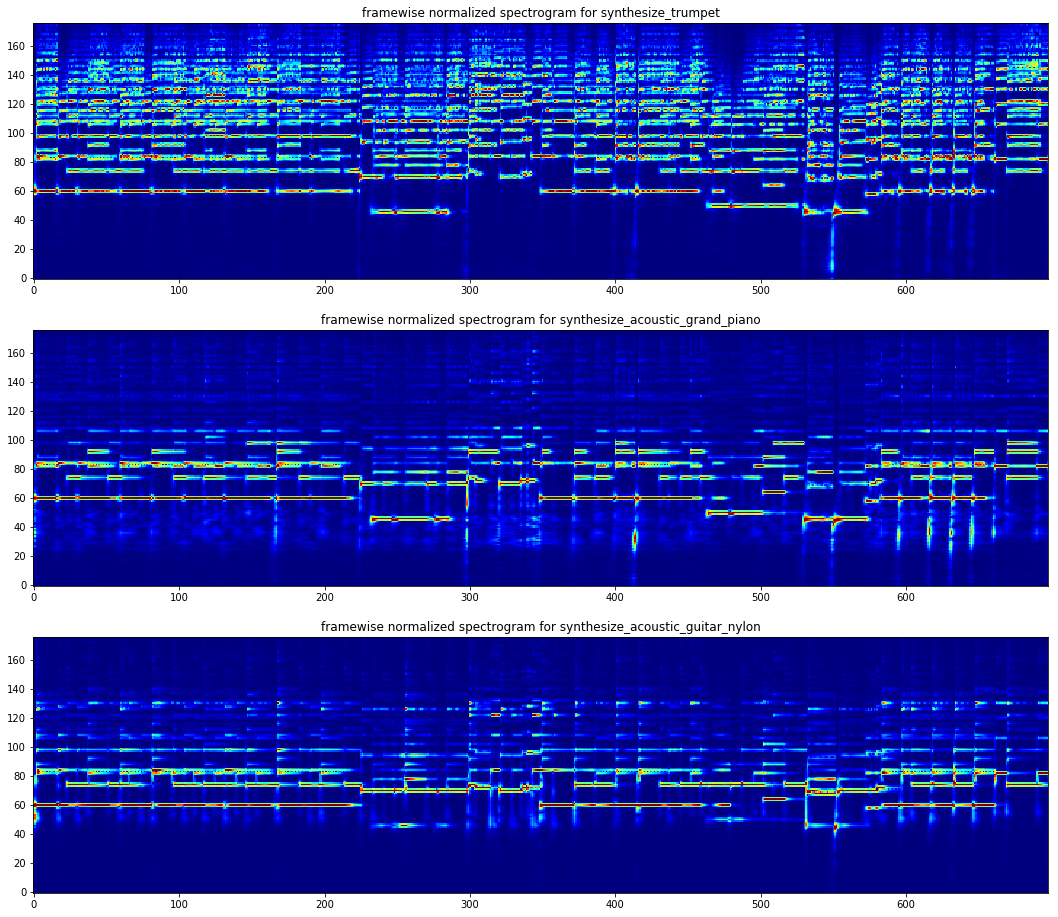

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(48, 16))
axs = axs.flat
for i, dataset in enumerate(datasets_names):
    print(dataset)
    spectrogram_result, _ = pass_through_spectrogram_function(f"{dataset}/test/audio/00_BN1-129-Eb_comp_hex.wav", normalize=True, normalize_mode='framewise')
    axs[i].imshow(spectrogram_result, cmap='jet', origin='lower')
    axs[i].title.set_text(f"framewise normalized spectrogram for {dataset}")

synthesize_trumpet
synthesize_acoustic_grand_piano
synthesize_acoustic_guitar_nylon


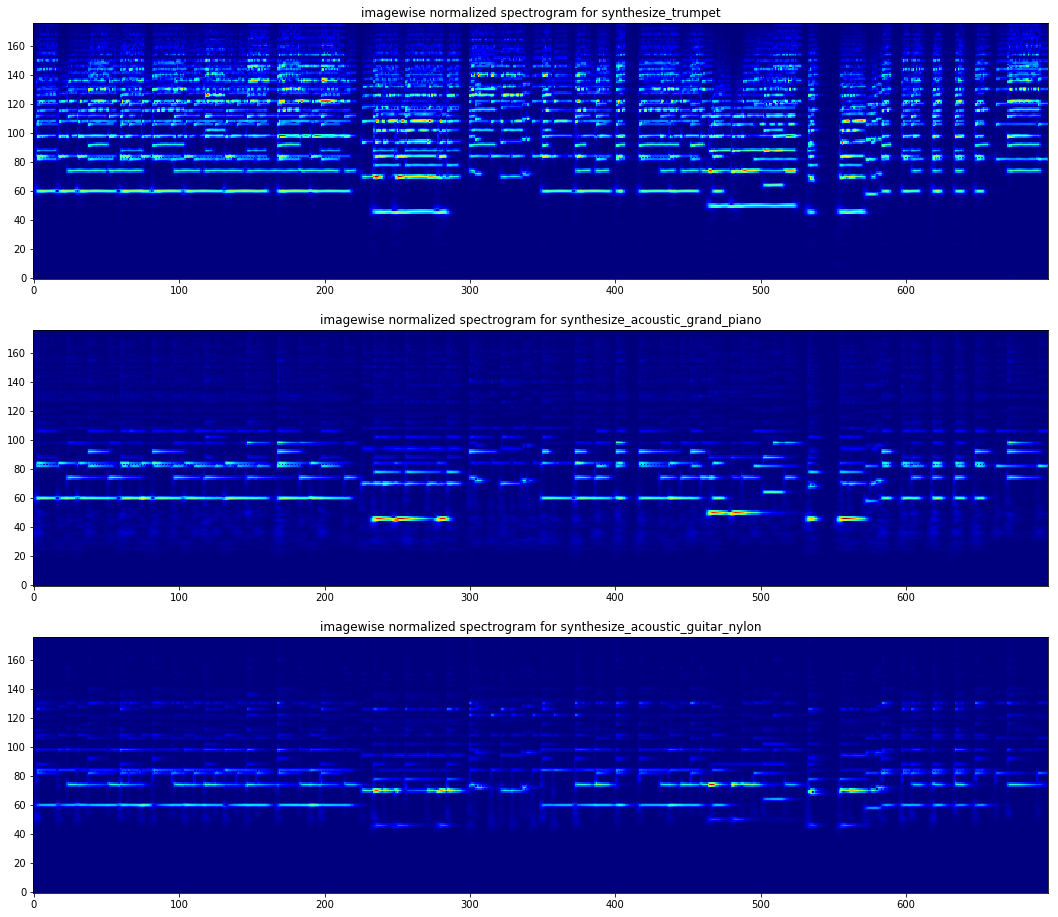

In [4]:

fig, axs = plt.subplots(3, 1, figsize=(48, 16))
axs = axs.flat
for i, dataset in enumerate(datasets_names):
    print(dataset)
    spectrogram_result, _ = pass_through_spectrogram_function(f"{dataset}/test/audio/00_BN1-129-Eb_comp_hex.wav", normalize=True, normalize_mode='imagewise')
    axs[i].imshow(spectrogram_result, cmap='jet', origin='lower')
    axs[i].title.set_text(f"imagewise normalized spectrogram for {dataset}")


In [5]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108

N_BINS = 229 # Default using Mel spectrograms
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048

# Comparison with real data spectrograms

In [6]:
from decoding import extract_notes
import numpy as np
from midi import save_midi
import matplotlib.pyplot as plt
from mir_eval.util import midi_to_hz
from midi2audio import FluidSynth
fs = FluidSynth(sample_rate=SAMPLE_RATE)

def convert_tsv_to_midi(tsv_path, midi_path, audio_length):
    print(f"audio length: {audio_length} sample rate: {SAMPLE_RATE} hop_length: {HOP_LENGTH}")
    n_keys = MAX_MIDI - MIN_MIDI + 1
    # This will affect the labels time steps
    n_steps = (audio_length - 1) // HOP_LENGTH + 1
    print(f"n_steps: {n_steps} n_keys: {n_keys}")
    label = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
    velocity = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
    midi = np.loadtxt(tsv_path, delimiter='\t', skiprows=1)
    for onset, offset, note, vel in midi:
        # Convert time to time step
        left = int(round(onset * SAMPLE_RATE / HOP_LENGTH))
        # Ensure the time step of onset would not exceed the last time step
        onset_right = min(n_steps, left + HOPS_IN_ONSET)
        frame_right = int(round(offset * SAMPLE_RATE / HOP_LENGTH))
        # Ensure the time step of frame would not exceed the last time step
        frame_right = min(n_steps, frame_right)
        offset_right = min(n_steps, frame_right + HOPS_IN_OFFSET)

        f = int(note) - MIN_MIDI
        label[left:onset_right, f] = 3
        label[onset_right:frame_right, f] = 2
        label[frame_right:offset_right, f] = 1
        velocity[left:frame_right, f] = vel

    onset = (label == 3).float()
    offset = (label == 1).float()
    frame = (label > 1).float()
    scaling = HOP_LENGTH / SAMPLE_RATE

    p_ref, i_ref, v_ref = extract_notes(onset, frame, velocity)
    p_ref = np.array([midi_to_hz(MIN_MIDI + midi) for midi in p_ref])
    i_ref = (i_ref * scaling).reshape(-1, 2)

    save_midi(midi_path, p_ref, i_ref, v_ref)

audio length: 2039295 sample rate: 16000 hop_length: 512
n_steps: 3983 n_keys: 88


/Users/mles/Projects/AutomaticMusicTranscription/automatic_music_transcription/data/decoding.py:81: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  for nonzero in onset_diff.nonzero():
fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.2.7
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'MAPS_MUS-alb_esp2_AkPnCGdD_synthesized.wav'..


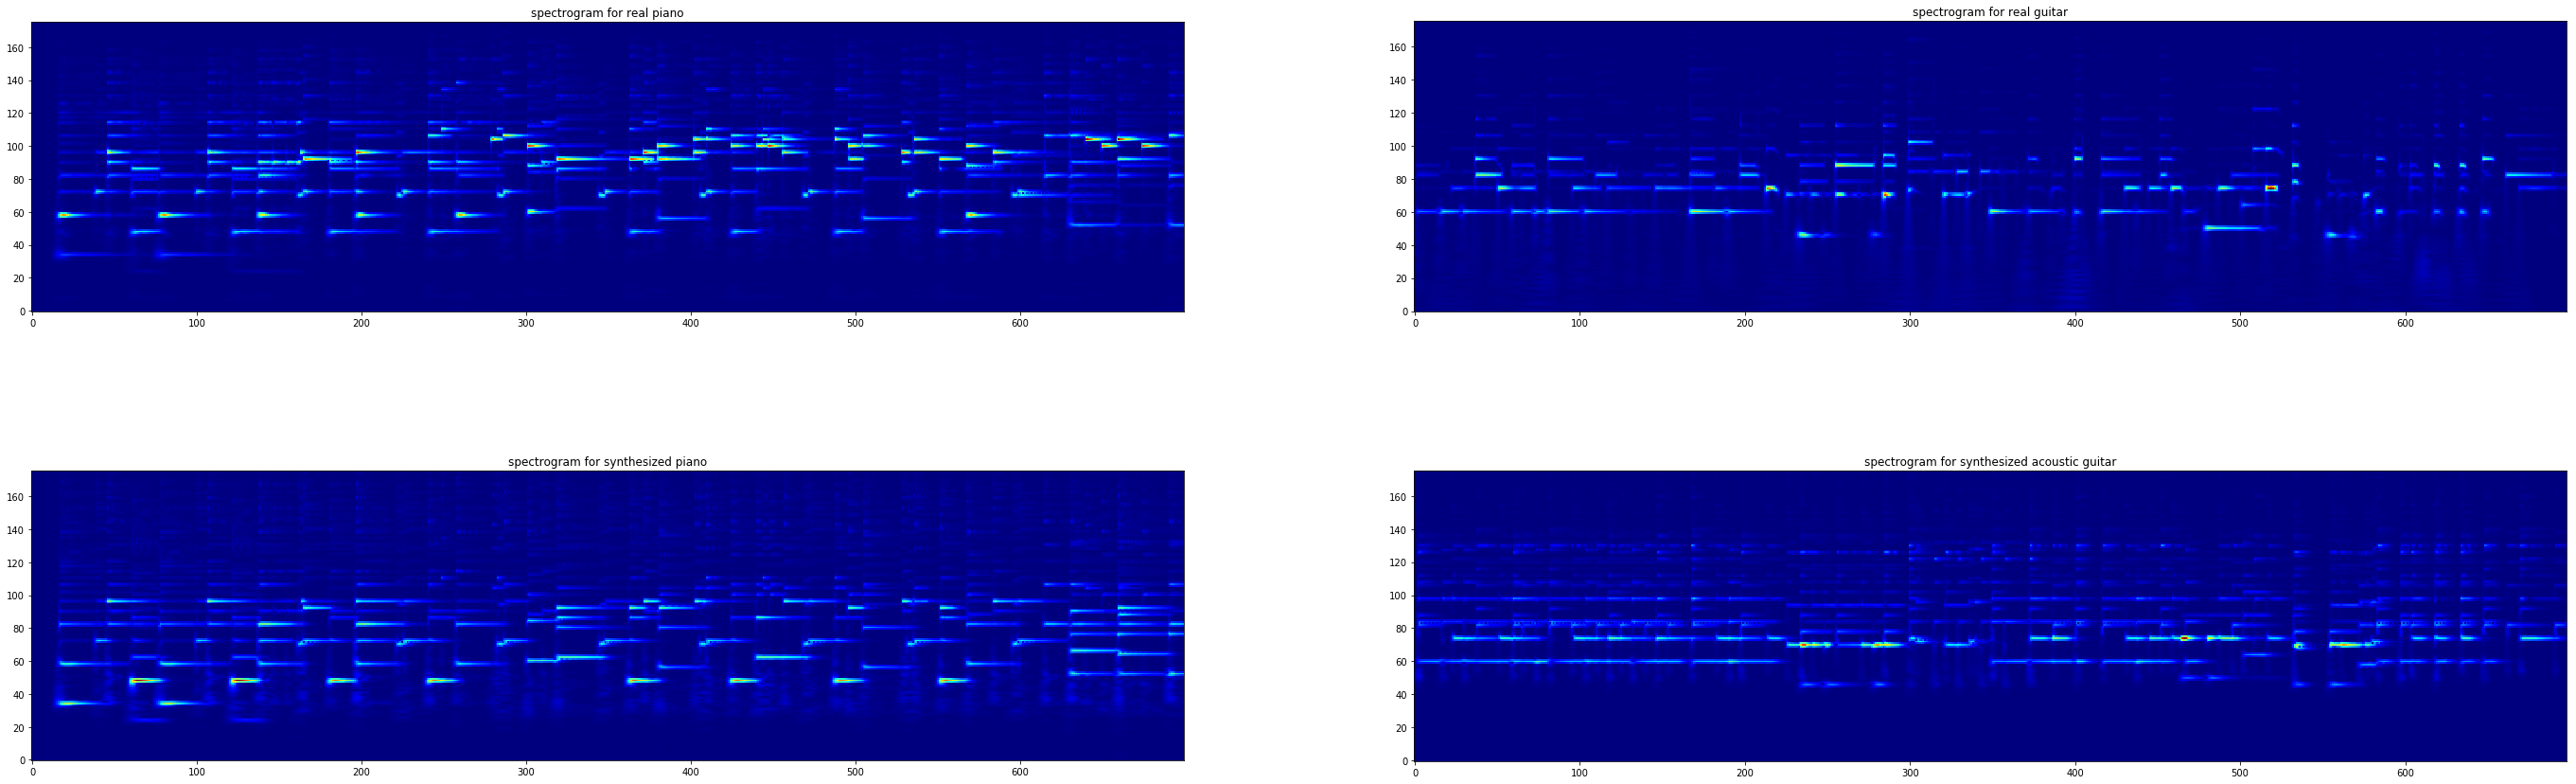

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(48, 16))
axs = axs.flat
spectrogram_result, audio = pass_through_spectrogram_function("MAPS/flac/MAPS_MUS-alb_esp2_AkPnCGdD.flac")
axs[0].imshow(spectrogram_result[:,:700], cmap='jet', origin='lower')
axs[0].title.set_text(f"spectrogram for real piano")

convert_tsv_to_midi("MAPS/tsv/matched/MAPS_MUS-alb_esp2_AkPnCGdD.tsv", "MAPS_MUS-alb_esp2_AkPnCGdD.mid", len(audio))
fs.midi_to_audio("MAPS_MUS-alb_esp2_AkPnCGdD.mid", 'MAPS_MUS-alb_esp2_AkPnCGdD_synthesized.wav')
spectrogram_result, _ = pass_through_spectrogram_function("MAPS_MUS-alb_esp2_AkPnCGdD_synthesized.wav")
axs[2].imshow(spectrogram_result[:,:700], cmap='jet', origin='lower')
axs[2].title.set_text(f"spectrogram for synthesized piano")

spectrogram_result, _ = pass_through_spectrogram_function("GuitarSet_extracted/audio/00_BN1-129-Eb_comp_hex.wav")
axs[1].imshow(spectrogram_result[:,:700], cmap='jet', origin='lower')
axs[1].title.set_text(f"spectrogram for real guitar")


spectrogram_result, _ = pass_through_spectrogram_function("synthesize_acoustic_guitar_nylon/test/audio/00_BN1-129-Eb_comp_hex.wav")
axs[3].imshow(spectrogram_result[:,:700], cmap='jet', origin='lower')
axs[3].title.set_text(f"spectrogram for synthesized acoustic guitar")